#### **Import Libraries**

In [1]:
# Standard library imports
import os

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall, compute_f1_score
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, concatenate_datasets




#### **Parameters**

In [2]:
seed = 1                        # Seed
prompt = True                  # Whether to include a prompt about who is likely to take up the treatment if offered
noise = False                    # Whether covariates can predict the takeup of treatment
sample_size = 10_000              # Sample Size
val_set_fraction = 0.25         # Fraction of sample used for validation set
data_version = 1                # version of synthetic data         
class_weight_type = 'standard'  
lr = 2e-4                       # Optimizer learning rate
warmup_ratio = 0.25             # Fraction of training epochs used for learning rate warm up
batch_size = 32                 # Number of observations in each mini-batch
epochs = 50                     # Number of training epochs
patience = 30                    
gamma = 0.0


#### **Seed**

In [3]:
np.random.seed(seed)

#### **Set Up Paths**

In [4]:
data_csv = f'./../../../toy-data/exp2/data_{data_version}.csv'

#### **Set Up Plotting**

In [5]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_24pt/Newsreader_24pt-ExtraBoldItalic.ttf


#### **First Stage Function**

In [6]:
conditions_not_covered = [
    "Short-term illnesses",
    "Temporary exhaustion",
    "Behavioral Traits and Conditions",
    "Having a quick temper without any underlying medical condition",
    "Certain Addictions",
    "Substance abuse disorders",
    "good health"
]

conditions_covered = [
    "Mobility impairments",
    "Visual impairments",
    "Hearing impairments",
    "Chronic illnesses",
    "Respiratory disorders",
    "Cardiovascular conditions",
    "Intellectual disabilities",
    "Learning disabilities",
    "Autism spectrum disorders",
    "Psychiatric disorders",
    "Traumatic brain injuries",
    "Alzheimer's disease and other dementias"
]

disabilities = conditions_covered + conditions_not_covered

# Create a list of (0,1)s
severity_indicator = [1 if disability in conditions_covered else 0 for disability in disabilities]

def fstage(var1, var2, var3, var4, var5, var6, var7, var8, var9):
    return 0.25*severity_indicator[var5] + 0.5*var9

#### **Read in Data**

In [7]:
import re 

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n'
string1 = "Note: Some tenants have access to a free lawyer others don't. This tenant **has access** to a free lawyer.\n\n"
string0 = "Note: Some tenants have access to a free lawyer others don't. This tenant **does not have access** to a free lawyer.\n\n"
if prompt:

    context = "Also Note: Access to a lawyer does not mean the tenant will be represented in court by a lawyer." \
        " If the tenant is given access to a lawyer, they must apply for representation." \
        " Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications." \
        " Providers can differ over what they consider to be a dissability."\
        " If a tenant's application is selected, they must follow-up with the provider to arange for legal representation." \
        " Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation."
else:
    context = ''

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4'], 
                                                 row['Var5'],
                                                 row['Var6'],
                                                 row['Var7'],
                                                 row['Var8'],
                                                 row['Var9']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                             string_b + string1 + 'Description:' + df['Description'].replace("\n", "") + '\n\n' + context,
                             string_b + string0 + 'Description:' + df['Description'].replace("\n", "") + '\n\n'+ context)

# Text + Instrument == 1
df['Treated_FullDescription'] = df.apply(lambda row: string_b + string1 + 'Description:' + row['Description'].replace("\n", "") + '\n\n' + context, axis=1)

# Text + Instrument == 0
df['Control_FullDescription'] = df.apply(lambda row: string_b + string0 + 'Description:' + row['Description'].replace("\n", "") + '\n\n' + context, axis=1)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + 0.1*np.random.normal(size=sample_size)

In [8]:
to_markdown(df['FullDescription'].values[0])

> Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
> Note: Some tenants have access to a free lawyer others don't. This tenant **does not have access** to a free lawyer.
> 
> Description:The tenant is a 33-year-old individual with mobility impairments who has been living in a small apartment complex for the past 49 months. They have a housing voucher that helps cover their rent, but they are currently behind on payments by $683. Despite their disability, the tenant takes pleasure in cooking on weekends and enjoys the companionship of their pet bird. Unfortunately, their family members do not contribute to the rent, leaving the tenant to shoulder the financial burden alone. The tenant's situation highlights the challenges faced by individuals with mobility issues who rely on limited resources to maintain their housing.
> 
> Also Note: Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.

#### **Plot Treatment Distribution**

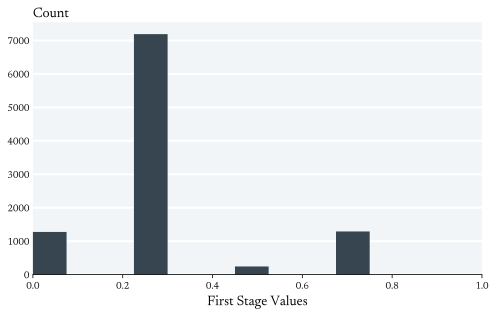

In [9]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('First Stage Values', size=14)
plt.show()

#### **Set Up Device**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Tokenizer**

In [11]:
model_id = "distilbert/distilbert-base-uncased" #"roberta-base"#"distilbert/distilbert-base-uncased"#
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.model_max_length = 512
print(tokenizer.model_max_length)

def tokenizer_function(example):
  return tokenizer(example["FullDescription"], truncation=True)

512


#### **Preprocess Data**

In [12]:
# Rename Treatment Variable to Lable because we're predicting the treatment
df = df.rename(columns={'Treatment': 'label'})

# Created Treated DataFrame
df_treated = df.copy()
df_treated.pop('FullDescription')

# Create Control DataFrame
df_control = df.copy()
df_control.pop('FullDescription')

# Rename Columns
df_treated = df_treated.rename(columns={'Treated_FullDescription': 'FullDescription'})
df_control = df_control.rename(columns={'Control_FullDescription': 'FullDescription'})

# Convert DataFrames to Datasets
original_dataset = Dataset.from_dict(df[['FullDescription','label']])
treated_dataset = Dataset.from_dict(df_treated[['FullDescription','label']])
control_dataset = Dataset.from_dict(df_control[['FullDescription','label']])

# Tokenize Datasets
tokenized_dataset = original_dataset.map(tokenizer_function, batched=True)
tokenized_treated_dataset = treated_dataset.map(tokenizer_function, batched=True)
tokenized_control_dataset = control_dataset.map(tokenizer_function, batched=True)

# Remove Column
tokenized_dataset = tokenized_dataset.remove_columns(['FullDescription'])
tokenized_treated_dataset = tokenized_treated_dataset.remove_columns(['FullDescription'])
tokenized_control_dataset = tokenized_control_dataset.remove_columns(['FullDescription'])

# Split Dataset
tokenized_dataset_split = tokenized_dataset.train_test_split(test_size=val_set_fraction, seed=42)
train_set = tokenized_dataset_split['train'].add_column('val_indicator', [0] * len(tokenized_dataset_split['train']))
val_set = tokenized_dataset_split['test'].add_column('val_indicator', [1] * len(tokenized_dataset_split['test']))

# Combining back into a single dataset for unified handling
combined_dataset = concatenate_datasets([train_set, val_set])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/7500 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/2500 [00:00<?, ? examples/s]

#### **DataLoaders**

In [13]:
treated_loader = DataLoader(tokenized_treated_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
control_loader = DataLoader(tokenized_control_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
all_loader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
loader_with_val_idx = DataLoader(combined_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
train_loader = DataLoader(train_set, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

#### **Model**

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           num_labels=2)
model = model.to(device)
#model = torch.compile(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **Optimizer and Scheduler**

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler =transformers.optimization.get_cosine_schedule_with_warmup(optimizer,int(warmup_ratio*len(train_loader)*epochs), len(train_loader)*epochs)

#### **Class Weights**

In [16]:
if class_weight_type == 'inverse':
    a = df.shape[0]/(df.shape[0] - df['label'].sum())
    b = df.shape[0]/df['label'].sum()
    a,b = a/(a + b), b/(a +b)
    class_weights = torch.tensor([a, b], device=device) 
elif class_weight_type == 'standard':
    class_weights = torch.tensor([1., 1.], device=device) 
print(f'Class Weights: {class_weights}')
criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='output')

Class Weights: tensor([1., 1.], device='cuda:0')


#### **Trainer**

In [17]:
metric_fn =  lambda a, b: (compute_f1_score(a,b), compute_recall(a,b))
yuri = EncoderTrainer(model, optimizer, scheduler, metric_fn, criterion, device, False)
early_stopping = EarlyStopping(patience)

#### **Train**

Epoch: 1, Train Loss: 0.4114, Val Loss: 0.2985:   0%|          | 0/50 [00:36<?, ?it/s]

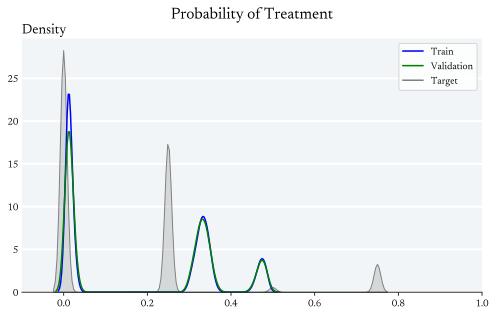

Epoch: 2, Train Loss: 0.2675, Val Loss: 0.2974:   2%|▏         | 1/50 [01:30<43:45, 53.58s/it]

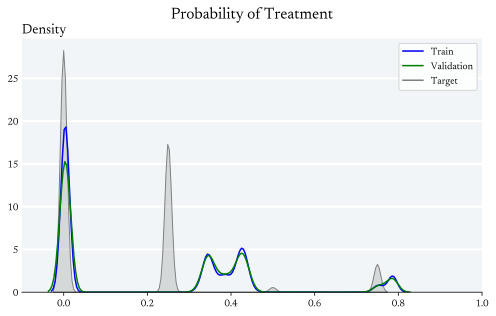

Epoch: 3, Train Loss: 0.2575, Val Loss: 0.2572:   4%|▍         | 2/50 [02:24<43:11, 54.00s/it]

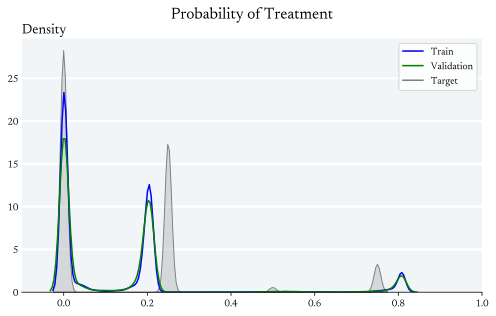

Epoch: 4, Train Loss: 0.2559, Val Loss: 0.2564:   6%|▌         | 3/50 [03:18<42:08, 53.80s/it]

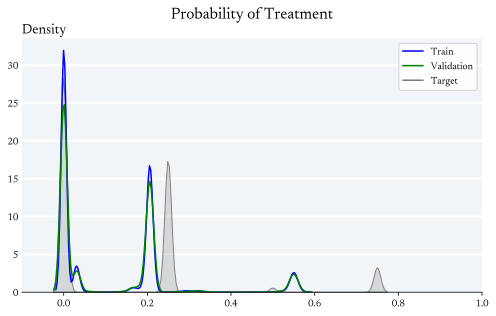

Epoch: 5, Train Loss: 0.2536, Val Loss: 0.3009:   8%|▊         | 4/50 [04:12<41:19, 53.90s/it]

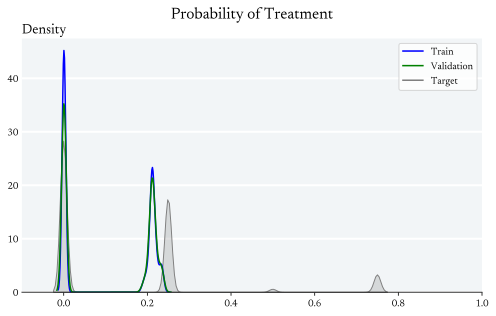

Epoch: 6, Train Loss: 0.2631, Val Loss: 0.2751:  10%|█         | 5/50 [05:06<40:20, 53.79s/it]

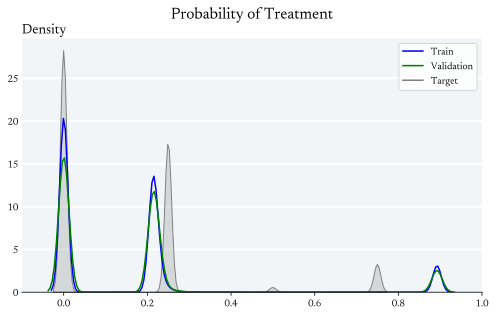

Epoch: 7, Train Loss: 0.3413, Val Loss: 0.4297:  12%|█▏        | 6/50 [05:59<39:26, 53.78s/it]

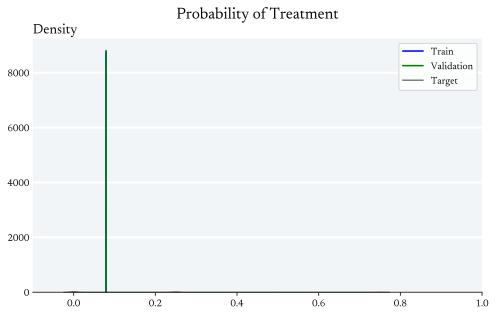

Epoch: 8, Train Loss: 0.3924, Val Loss: 0.3168:  14%|█▍        | 7/50 [06:53<38:23, 53.58s/it]

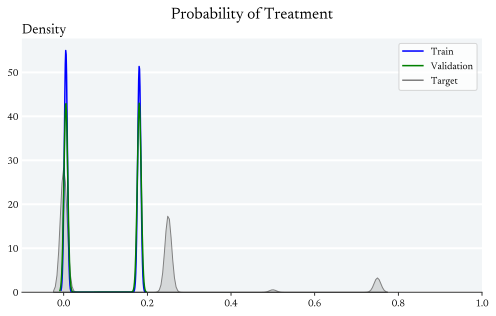

Epoch: 9, Train Loss: 0.2882, Val Loss: 0.2895:  16%|█▌        | 8/50 [07:46<37:31, 53.60s/it]

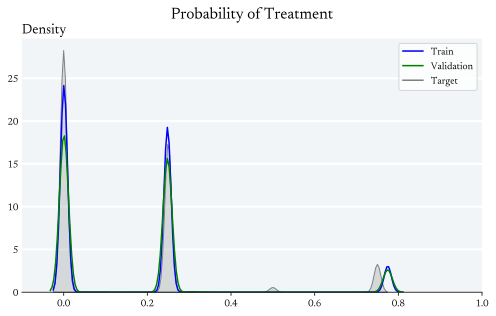

Epoch: 9, Train Loss: 0.2882, Val Loss: 0.2895:  18%|█▊        | 9/50 [08:17<37:45, 55.25s/it]


KeyboardInterrupt: 

: 

In [18]:
# Compute Initial Train/Validation Losses
evaluation_losses = [yuri.evaluate(val_loader)]
training_losses =  [yuri.evaluate(train_loader)]
pbar =  tqdm(range(epochs), desc=f'Epoch: 0, Train Loss: {training_losses[0]:.3f}, Val Loss: {evaluation_losses[0]:.3f}')

# Initialize Empty Lists to Store Recall and Learning Rate Histories
metric_history = []
learning_rate_history = []

for epoch in pbar:

    train_loss, metrics, current_lr = yuri.train(train_loader)

    training_losses.append(train_loss)
    metric_history.append(metrics)
    learning_rate_history.append(current_lr)
    
    val_loss = yuri.evaluate(val_loader)
    evaluation_losses.append(val_loss)

    # Update the progress bar description for the current epoch
    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    
    # Call early stopping
    early_stopping(val_loss, model, epoch)
    if early_stopping.early_stop:
        print("***Early stopping***")
        print(f"Min Validation Loss: {early_stopping.best_epoch}")
        print(f"Current Epoch: {epoch}")
        break

    # Create figure and axes with specific settings
    Dhat, labels, val_indicator = predict(model, loader_with_val_idx, device)
    fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
    ax = plt.axes(facecolor=(.95, .96, .97))
    ax.set_title('Probability of Treatment', size=16, pad=20)

    # Set visibility of some spines
    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    # Add text to the axes
    ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

    # Set Y-axis tick parameters and grid
    ax.yaxis.set_tick_params(length=0)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)

    # Plot the KDE plot
    sns.kdeplot(Dhat[val_indicator==0].reshape(-1,), color='blue', fill=False, bw_adjust=0.25, label='Train')
    sns.kdeplot(Dhat[val_indicator==1].reshape(-1,), color='green', fill=False, bw_adjust=0.25, label='Validation')
    fill_kde = sns.kdeplot((df['FStage_Value']*df['Instrument']).values.reshape(-1,), fill=True, color='grey', bw_adjust=0.25, label='Target')

    # Create custom legend handles
    from matplotlib.lines import Line2D
    legend_handles = [
        Line2D([0], [0], color='blue', label='Train'),
        Line2D([0], [0], color='green', label='Validation'),
        Line2D([0], [0], color='grey', label='Target')
    ]

    # Set custom legend
    plt.legend(handles=legend_handles)
    plt.ylabel('')
    plt.xlim(-0.1,1)
    plt.show()

model.load_state_dict(torch.load('checkpoint.pt'))

In [ ]:
Dhat, labels, val_indicator = predict(model, loader_with_val_idx, device)

In [ ]:
qs = np.linspace(0, 1, 100)
ys1 = np.quantile(Dhat, qs)
ys2 = np.quantile(df['FStage_Value'].values, qs)
plt.plot(qs, ys1)
plt.plot(qs, ys2)
plt.show()

#### **Loss History**

In [ ]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Loss', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot(evaluation_losses, label='Validation')
plt.plot(training_losses, label='Train')
plt.axvline(early_stopping.best_epoch + 1, color='black', linestyle='--')
plt.legend()
plt.xlabel('Epochs', size=14)
plt.show()

#### **F1-Score**

In [ ]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='F1-Score', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot([i[0] for i in metric_history])
plt.axvline(early_stopping.best_epoch + 1, color='black', linestyle='--')
plt.xlabel('Epochs', size=14)
plt.ylim(0, 1)
plt.show()

#### **Recall**

In [ ]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Recall', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot([i[1][0][0] for i in metric_history], label='0')
plt.plot([i[1][0][1] for i in metric_history], label='1')
plt.axvline(early_stopping.best_epoch + 1, color='black', linestyle='--')
plt.xlabel('Epochs', size=14)
plt.legend()
plt.show()

#### **Entire Data Set Predictions**

In [ ]:
Dhat, labels, val_indicator = predict(model, loader_with_val_idx, device)

In [ ]:
# Create figure and axes with specific settings
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Probability of Treatment', size=16, pad=20)

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

# Plot the KDE plot
sns.kdeplot(Dhat[val_indicator==0].reshape(-1,), color='blue', fill=False, bw_adjust=0.25, label='Train')
sns.kdeplot(Dhat[val_indicator==1].reshape(-1,), color='green', fill=False, bw_adjust=0.25, label='Validation')
fill_kde = sns.kdeplot((df['FStage_Value']*df['Instrument']).values.reshape(-1,), fill=True, color='grey', bw_adjust=0.25, label='Target')

# Create custom legend handles
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color='blue', label='Train'),
    Line2D([0], [0], color='green', label='Validation'),
    Line2D([0], [0], color='grey', label='Target')
]

# Set custom legend
plt.legend(handles=legend_handles)
plt.ylabel('')
plt.show()

#### **Predicted Treatment on Ordered Dataset**

In [ ]:
Dhat, _ = predict(model, all_loader, device)
Dhat = Dhat.reshape(-1,1)

#### **Probability of Treatment Given (Instrument==0)**

In [ ]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Probability of Treatment Given (Instrument==0)', size=16, pad=20)

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

# Plot the KDE plot
sns.kdeplot(Dhat[df['Instrument'].values==0].reshape(-1,), color='#36454F', fill=False, bw_adjust=0.25)
plt.xlim(0, 1)
plt.ylabel('')
plt.show()

#### **Probability of Treatment Given (Instrument==1)**

In [ ]:
# Create figure and axes with specific settings
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Probability of Treatment Given (Instrument==1)', size=16, pad=20)

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

# Plot the KDE plot
sns.kdeplot(Dhat[df['Instrument']==1], color='#36454F', fill=True, bw_adjust=0.25, label='Prediction')
sns.kdeplot(df['FStage_Value'][df['Instrument']==1], color='purple', fill=True, bw_adjust=0.25, label='Truth')
plt.ylabel('')
plt.xlabel('')
plt.legend()
plt.show()

In [ ]:
v = (df['FStage_Value']*df['Instrument']).values
plt.scatter(v, Dhat.reshape(-1,))
plt.plot([0,1], [0,1])
plt.xlim(0,1)
plt.ylim(0,1)

#### **Save Results**

In [ ]:
# Assuming df is your DataFrame and Dhat is already defined in your context
Dhat1, _ = predict(model, treated_loader, device)
Dhat1 = Dhat1.reshape(-1,1)
Dhat0, _ = predict(model, control_loader, device)
Dhat0 = Dhat0.reshape(-1,1)
expected_value = (0.5*Dhat1 + 0.5*Dhat0)
residuals = Dhat - expected_value
idx = np.abs(residuals).reshape(-1,) > 0.001
y = np.array(df['Outcome'].values.reshape(-1,1))
est = np.linalg.lstsq(np.hstack((residuals[idx], np.ones_like(residuals[idx]))), y[idx])[0][0]

df_result = pd.DataFrame({'Estimate': est})

# Define the path for the CSV file
file_path = f'./../../../toy-data/exp2/results/llms_{data_version}_{prompt}_{sample_size}_{noise}.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    # If the file does not exist, write with headers
    df_result[['Estimate']].to_csv(file_path, mode='w', header=True, index=False)
else:
    # If the file exists, append without headers
    df_result[['Estimate']].to_csv(file_path, mode='a', header=False, index=False)

est